# Recurrent neural networks

Get IBM stock market data and evaluate prediction on a set of recurrent neural networks.

Dataset can be downloaded from https://www.kaggle.com/szrlee/stock-time-series-20050101-to-20171231



## Step 1

Load data and prepare the dataset

In [ ]:
# import
import pandas as pd
import csv
import numpy as np
# we suppose 'closed domain' - no other data outside from the defined limits

data=pd.read_csv('IBM_2006-01-01_to_2018-01-01.csv',header=0, delimiter=',', index_col='Date', parse_dates=['Date'])
print(data.shape)
data.head()

(3020, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,82.45,82.55,80.81,82.06,11715200,IBM
2006-01-04,82.20,82.50,81.33,81.95,9840600,IBM
2006-01-05,81.40,82.90,81.00,82.50,7213500,IBM
2006-01-06,83.95,85.03,83.41,84.95,8197400,IBM
2006-01-09,84.10,84.25,83.38,83.73,6858200,IBM


In [ ]:
# Visualizing Close price history
import plotly.express as px

fig = px.line(data,  y="Close", title='Close price chart')
fig.show()

In [ ]:
# Splitting the data into train and test sets
close_prices = data['Close']
training_set = close_prices[:'2016']
test_set = close_prices['2017':]
print(len(training_set))
print(len(test_set))

2769
251


In [ ]:
from sklearn.preprocessing import MinMaxScaler 
# Scaling the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(training_set.values.reshape(-1,1))
scaled_data.shape

(2769, 1)

In [ ]:
# Data Preparation 
window_size = 30

x_train = []
y_train = []

# Sliding window
for i in range(window_size, len(scaled_data)):      
    x_train.append(scaled_data[i-window_size:i, 0])
    y_train.append(scaled_data[i, 0])                     

# Turning lists into np arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshaping for efficient modelling to be then fed into LSTM Network 
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [ ]:
print(x_train.shape)
print(y_train.shape)

(2739, 30, 1)
(2739,)


In [ ]:
# Preparing test set
real_prices = test_set.values
total_dataset = pd.concat((training_set, test_set), axis=0)
len_train_data = len(total_dataset)-len(test_set)

model_inputs = total_dataset[len_train_data-window_size:].values
model_inputs = model_inputs.reshape(-1,1) # -1 here indicated that we keep the same the dimension meaning dimension (3,) becomes here (3,1)

# Normalzing the model inputs as we did previously but now for the test data inputs
model_inputs = scaler.transform(model_inputs)

In [ ]:
# Preparing x_test 
x_test = []
for day in range(window_size,len(model_inputs)):
    x_test.append(model_inputs[day-window_size:day,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))


# Step 2

Perform prediction by using feed-forward neural network (sliding window)

In [ ]:
import tensorflow as tf
from keras.optimizers import Adam
from keras.layers import *
from keras.models import *
# Simple feed-forward neural network

model_ffn = Sequential()
model_ffn.add(Flatten(input_shape=(x_train.shape[1],1))) # Using flatten to reshape the inputs
model_ffn.add(Dense(16, activation="relu"))
model_ffn.add(Dense(1, activation="linear"))
model_ffn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 16)                496       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling and fitting the model
model_ffn.compile(optimizer='adam', loss='mean_squared_error', metrics="mse")
hist_ffn = model_ffn.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
86/86 [==============================] - 2s 4ms/step - loss: 0.0098 - mse: 0.0098
Epoch 2/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0035 - mse: 0.0035
Epoch 3/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0028 - mse: 0.0028
Epoch 4/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0023 - mse: 0.0023
Epoch 5/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0018 - mse: 0.0018
Epoch 6/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0016 - mse: 0.0016
Epoch 7/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0013 - mse: 0.0013
Epoch 8/10
86/86 [==============================] - 0s 5ms/step - loss: 0.0011 - mse: 0.0011
Epoch 9/10
86/86 [==============================] - 0s 4ms/step - loss: 0.0010 - mse: 0.0010
Epoch 10/10
86/86 [==============================] - 0s 4ms/step - loss: 9.1143e-04 - mse: 9.1143e-04


In [ ]:
# predict the prices
predicted_prices_ffn = model_ffn.predict(x_test)
predicted_prices_ffn = scaler.inverse_transform(predicted_prices_ffn)

8/8 [==============================] - 0s 3ms/step


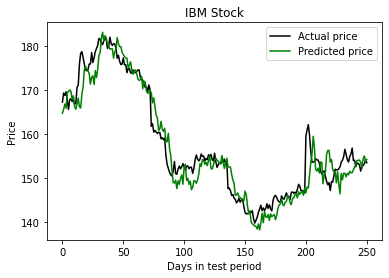

In [ ]:
# Plotting the predictions
import matplotlib.pyplot as plt

plt.plot(real_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices_ffn, color= 'green', label="Predicted price")
plt.title("IBM Stock")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend()
plt.show()

## Step 3

Perform prediction by using RNN

In [ ]:
# Building simple RNN model
model_rnn = Sequential()
model_rnn.add(SimpleRNN(units=32, input_shape=(x_train.shape[1],1), activation='tanh'))
model_rnn.add(Dense(units=8, activation='tanh'))
model_rnn.add(Dense(units=1, activation='linear'))
model_rnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1,361
Trainable params: 1,361
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling and fitting the model
model_rnn.compile(optimizer='adam', loss='mean_squared_error', metrics="mse")
hist_rnn = model_rnn.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
86/86 [==============================] - 3s 14ms/step - loss: 0.0313 - mse: 0.0313
Epoch 2/10
86/86 [==============================] - 1s 13ms/step - loss: 6.1966e-04 - mse: 6.1966e-04
Epoch 3/10
86/86 [==============================] - 1s 14ms/step - loss: 5.2791e-04 - mse: 5.2791e-04
Epoch 4/10
86/86 [==============================] - 1s 13ms/step - loss: 4.7421e-04 - mse: 4.7421e-04
Epoch 5/10
86/86 [==============================] - 1s 12ms/step - loss: 4.3912e-04 - mse: 4.3912e-04
Epoch 6/10
86/86 [==============================] - 1s 14ms/step - loss: 4.0982e-04 - mse: 4.0982e-04
Epoch 7/10
86/86 [==============================] - 1s 13ms/step - loss: 3.8111e-04 - mse: 3.8111e-04
Epoch 8/10
86/86 [==============================] - 1s 12ms/step - loss: 3.5378e-04 - mse: 3.5378e-04
Epoch 9/10
86/86 [==============================] - 1s 11ms/step - loss: 3.3665e-04 - mse: 3.3665e-04
Epoch 10/10
86/86 [==============================] - 1s 12ms/step - loss: 3.2104e-04 - mse

In [ ]:
# Predicting the prices
predicted_prices_rnn = model_rnn.predict(x_test)
predicted_prices_rnn = scaler.inverse_transform(predicted_prices_rnn) # Have to inverse transform to "un-normalize" the values

8/8 [==============================] - 0s 5ms/step


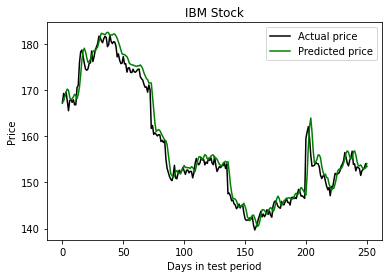

In [ ]:
# Plotting the predictions
plt.plot(real_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices_rnn, color= 'green', label="Predicted price")
plt.title("IBM Stock")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend()
plt.show()

## Step 4

Perform prediction by using LSTM

In [ ]:
# Building LSTM model
model_lstm = Sequential()
model_lstm.add(InputLayer(input_shape=(x_train.shape[1], 1)))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(LSTM(50, activation='relu'))
model_lstm.add(Dense(50, activation='relu'))
model_lstm.add(Dense(1, activation='linear'))
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 30, 50)            100       
                                                                 
 lstm (LSTM)                 (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 50)                2550      
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 22,901
Trainable params: 22,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling and fitting the model
model_lstm.compile(optimizer='adam',loss='mean_squared_error', metrics="mse")
hist_lstm = model_lstm.fit(x_train, y_train, batch_size= 32, epochs=10)

Epoch 1/10
86/86 [==============================] - 6s 24ms/step - loss: 0.0355 - mse: 0.0355
Epoch 2/10
86/86 [==============================] - 2s 19ms/step - loss: 7.0865e-04 - mse: 7.0865e-04
Epoch 3/10
86/86 [==============================] - 2s 19ms/step - loss: 5.0223e-04 - mse: 5.0223e-04
Epoch 4/10
86/86 [==============================] - 2s 19ms/step - loss: 4.0710e-04 - mse: 4.0710e-04
Epoch 5/10
86/86 [==============================] - 2s 18ms/step - loss: 3.9364e-04 - mse: 3.9364e-04
Epoch 6/10
86/86 [==============================] - 2s 19ms/step - loss: 3.3661e-04 - mse: 3.3661e-04
Epoch 7/10
86/86 [==============================] - 2s 19ms/step - loss: 3.1651e-04 - mse: 3.1651e-04
Epoch 8/10
86/86 [==============================] - 2s 19ms/step - loss: 3.0955e-04 - mse: 3.0955e-04
Epoch 9/10
86/86 [==============================] - 2s 19ms/step - loss: 2.7237e-04 - mse: 2.7237e-04
Epoch 10/10
86/86 [==============================] - 2s 19ms/step - loss: 2.6204e-04 - mse

In [ ]:
# predict the prices
predicted_prices_lstm = model_lstm.predict(x_test)
predicted_prices_lstm = scaler.inverse_transform(predicted_prices_lstm)

8/8 [==============================] - 0s 7ms/step


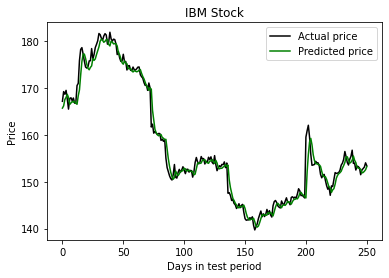

In [ ]:
# Plotting the predictions
plt.plot(real_prices, color='black', label=f"Actual price")
plt.plot(predicted_prices_lstm, color= 'green', label="Predicted price")
plt.title("IBM Stock")
plt.xlabel("Days in test period")
plt.ylabel("Price")
plt.legend()
plt.show()

## Step 5

Comparing all above results by using MSE error and determining the best architecture. You can do tests on more stock data than IBM for better results.

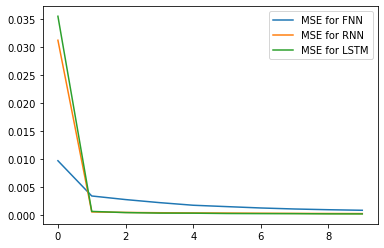

In [ ]:
# Let's plot the Mean Squared Error(MSE) of the above 3 models
plt.plot(hist_ffn.history["mse"], label="MSE for FNN")
plt.plot(hist_rnn.history["mse"], label="MSE for RNN")
plt.plot(hist_lstm.history["mse"], label="MSE for LSTM")
plt.legend()
# print(hist_ffn.history)

In [ ]:
from sklearn.metrics import mean_squared_error
# Calculating mse for the above 3 models using "mean_squared_error" from sklearn.metrics
mse_ffn = mean_squared_error(test_set,predicted_prices_ffn.flatten())
mse_rnn = mean_squared_error(test_set,predicted_prices_rnn.flatten())
mse_lstm = mean_squared_error(test_set,predicted_prices_lstm.flatten())

print(mse_ffn,mse_rnn,mse_lstm)

12.54178156438101 5.21081958780892 3.4954953399212934


**From the above we can conclude that LSTM model is better than Feed forward and SimpleRNN models. Even though the predicted graphs of SimpleRNN is similiar to LSTM the MSE is less for the LSTM model.**